In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dropout,  Input, Layer,Conv1DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from pandas_datareader import data

from PyEMD import EMD,EEMD,CEEMDAN,Visualisation

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
shares_name='LLOY.L'

In [4]:
start = '2017-01-01'
end = '2019-01-01'
GSPC = pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])#Choose the data
print(GSPC)
GSPC.isnull().sum().sort_values(ascending = False)

            Adj Close
Date                 
2017-01-03  49.659496
2017-01-04  49.774754
2017-01-05  49.682549
2017-01-06  50.643150
2017-01-09  50.120583
...               ...
2018-12-21  42.512680
2018-12-24  42.042244
2018-12-27  41.291195
2018-12-28  42.265083
2018-12-31  42.793293

[505 rows x 1 columns]


Adj Close    0
dtype: int64

In [5]:
start = '2017-01-01'
end = '2019-01-01'
GSPC_test = pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])#Choose the data
GSPC_test

,Adj Close
Date,
2017-01-03,49.659496
2017-01-04,49.774757
2017-01-05,49.682545
2017-01-06,50.643154
2017-01-09,50.120575
...,...
2018-12-21,42.512680
2018-12-24,42.042248
2018-12-27,41.291195


In [6]:
def emd_calculate(data,emdtype=EMD, plots=True):
    EMD_C=emdtype()#EMD,EEMD,CEEMDAN
    imfs = EMD_C(data.values.reshape(len(data)))
        
    if plots:
        series_index = data.index
        fig = plt.figure(figsize=(16,2*len(imfs)))
        plt.subplot(1+len(imfs), 1, 1 )
        plt.plot(series_index, data, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')

        # Plot IMFs
        for i in range(len(imfs)):
            plt.subplot(1 +len(imfs),1,2 + i)
            plt.plot(series_index, imfs[i, :], color='#F27F19')
            plt.ylabel('IMF'+str(i))
        plt.show()
    imfs=pd.DataFrame(imfs,columns=data.index)
    return imfs

In [7]:
def create_noisy(data,percentage=0.5,size=10):
    data_noisy = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        data_noisy= pd.concat([data_noisy,pd.Series(data.values[i-window:i,0])], axis=1)
    return data_noisy.T

In [8]:
def create_pure(data,percentage=0.5,size=10,emdtype=EMD,emdsum=1):
    data_pure = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        temp=emd_calculate(data[i-window:i],plots=False,emdtype=emdtype)
        temp_1= reconstruction(temp)
        data_pure= pd.concat([data_pure,pd.Series(temp_1.values[emdsum,:])], axis=1)
    return data_pure.T

In [9]:
def reconstruction(data_emd):
    reconstruction = pd.DataFrame()
    for i in range(len(data_emd)):
        reconstruction['sum'+str(i)]=data_emd.iloc[i:,:].sum(axis=0)
    return reconstruction.T

In [10]:
GSPC_pure=create_pure(GSPC)

GSPC_noisy=create_noisy(GSPC)

In [11]:
mm_t_g = MinMaxScaler()
noise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
prue_mm=mm_t_g.fit_transform(GSPC_pure.T).T
print(prue_mm.shape)
print(noise_mm.shape)

(26, 252)
(26, 252)


In [12]:
X_train_mm = np.asarray(noise_mm)
X_train_mm=X_train_mm.reshape((len(X_train_mm), len(X_train_mm[0]), 1))
Y_train_mm = np.asarray(prue_mm)
Y_train_mm=Y_train_mm.reshape((len(Y_train_mm), len(Y_train_mm[0]), 1))
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0,shuffle=False)

In [13]:
keras.backend.clear_session()

In [14]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu',kernel_constraint=max_norm(1), padding='same',input_shape=(None, 1)))
    model.add(Conv1D(32, kernel_size=3,activation='relu',kernel_constraint=max_norm(1),padding='same'))
    model.add(Conv1DTranspose(32, kernel_size=3, activation='relu',kernel_constraint=max_norm(1), padding='same'))
    model.add(Conv1DTranspose(128, kernel_size=3,activation='relu',kernel_constraint=max_norm(1),padding='same'))
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mae'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         512       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          12320     
                                                                 
 conv1d_transpose (Conv1DTra  (None, None, 32)         3104      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, None, 128)        12416     
 ranspose)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 1)           385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-traina

In [15]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=0, callbacks=[callback])

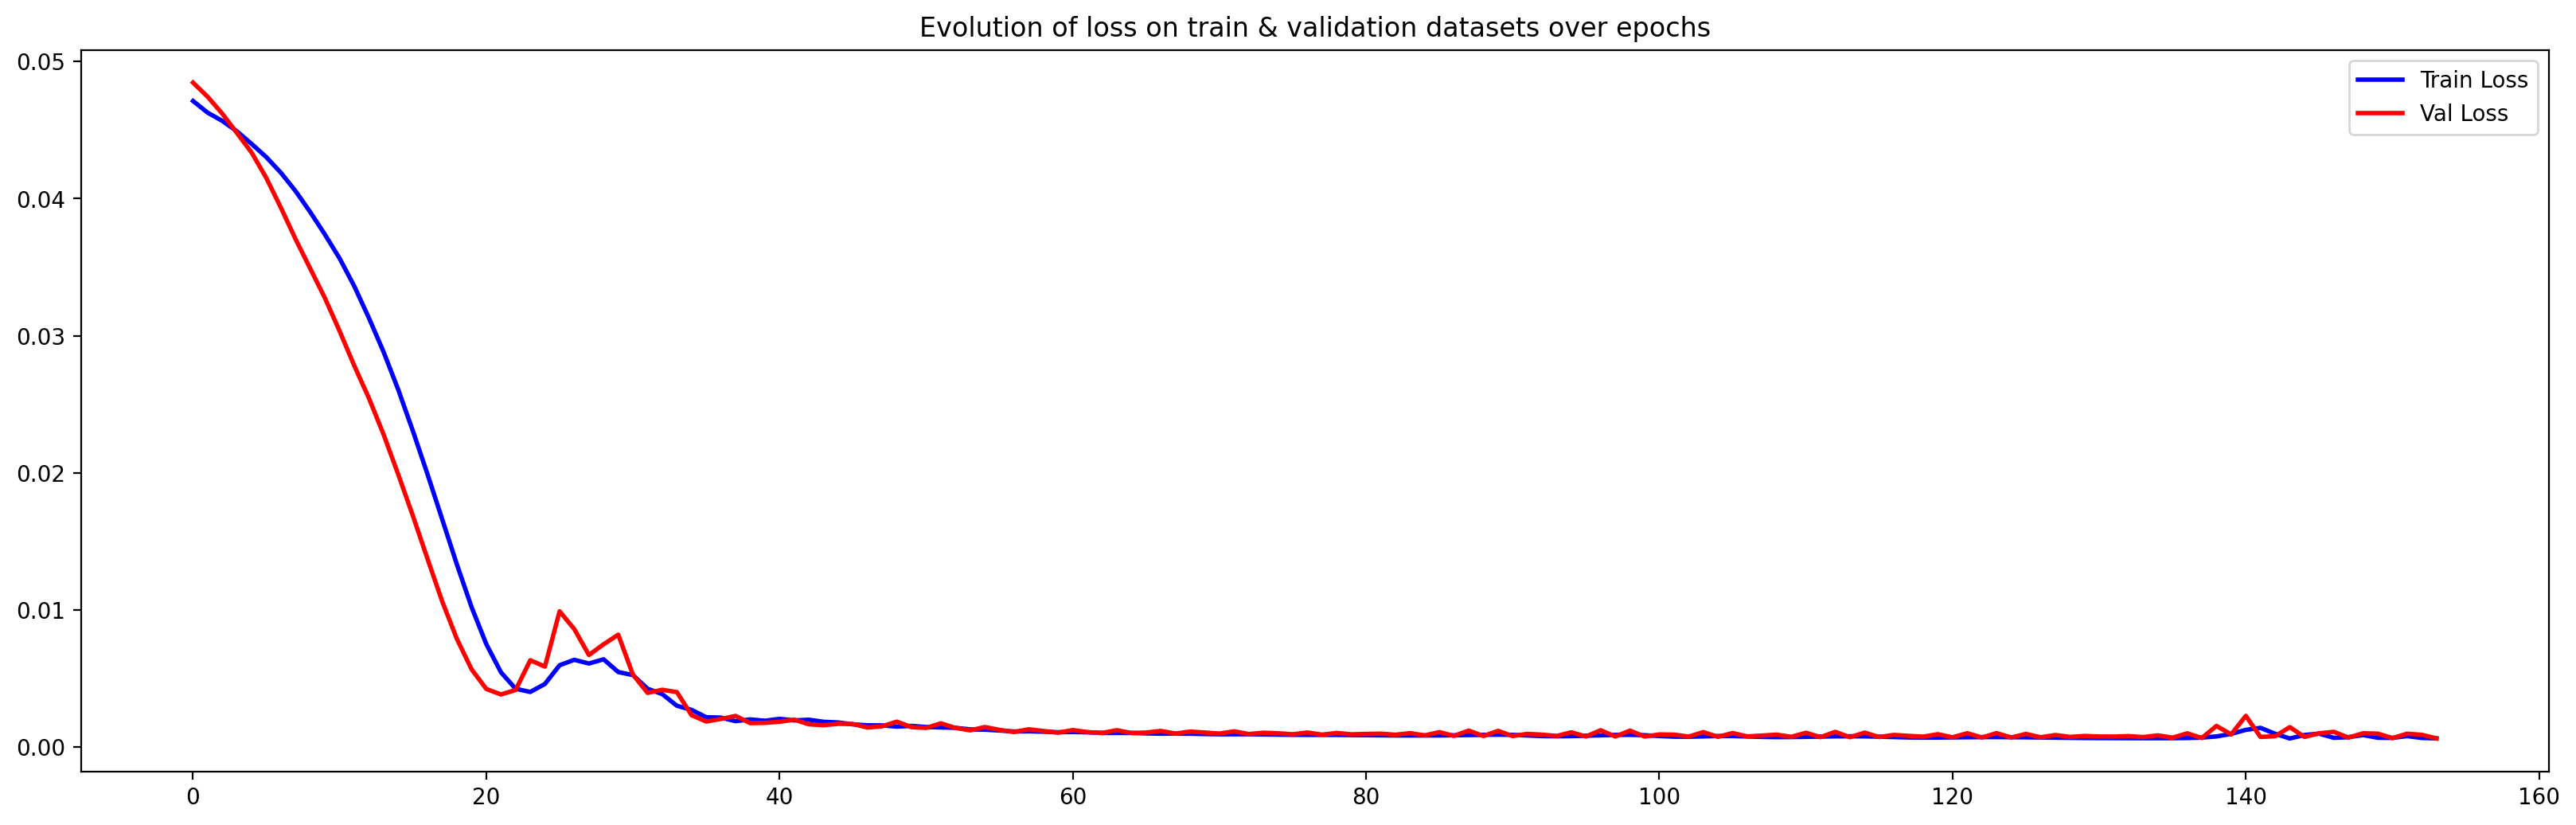

In [16]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']

plt.figure(figsize=(20,6),dpi=200)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

1/1 [==============================] - 0s 117ms/step


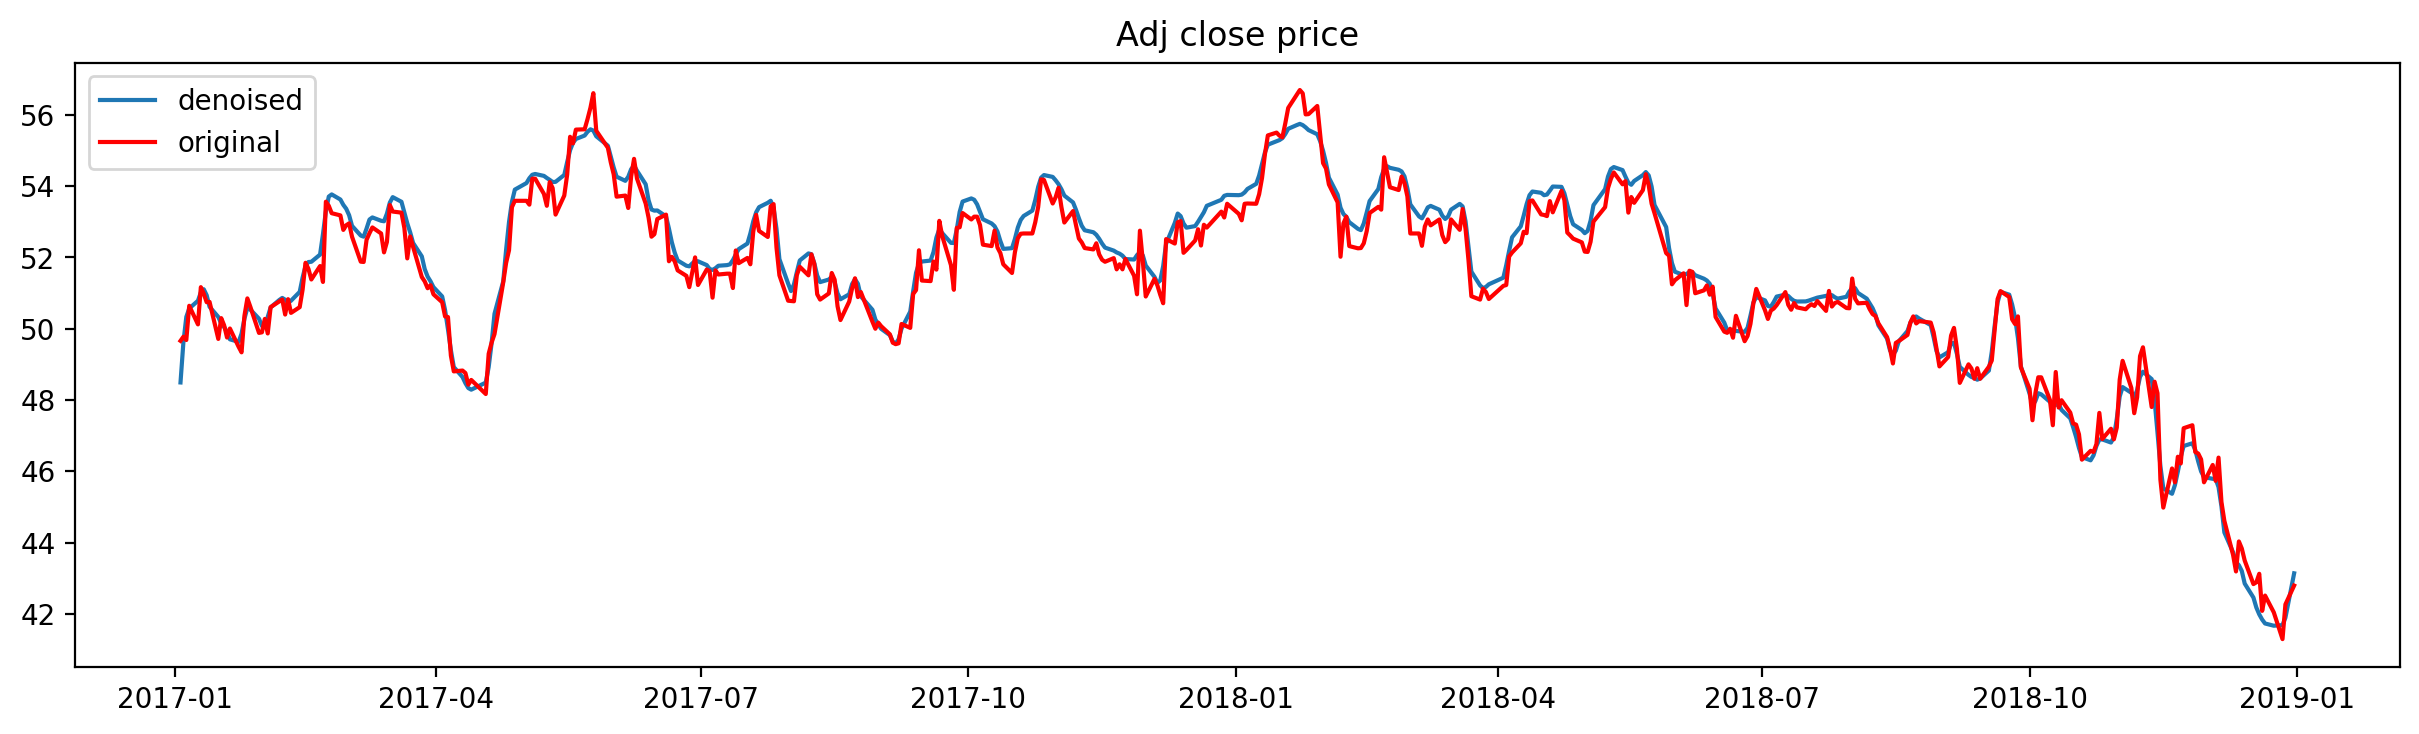

In [17]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(GSPC_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
noise_mm_T=pd.DataFrame(noise_mm_T,columns=['Adj Close'],index=GSPC_test.index)
Y_test_mm_cnn=pd.DataFrame(Y_test_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn)
plt.plot(GSPC_test,'r')
plt.title('Adj close price')
plt.legend(['denoised', 'original'], loc='upper left')

# regression

In [18]:
original=GSPC_test
recon=pure_mm_cnn

In [19]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['Adj Close'].shift(i)
    return ret_dataset

In [20]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

0.4854642053779993
0.33478136566963057
0.721844529652139
0.2497828330183771
2.1031131392331344
0.20475815381519724
0.23542065205721174
0.3831487432734121
3.0770431429374163
6.304527306180694
The last MSE: 6.304527306180694
The average MSE: 1.4099884071215212


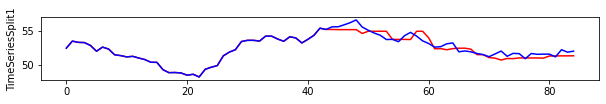

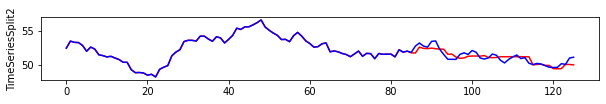

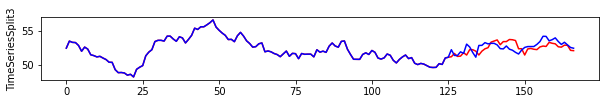

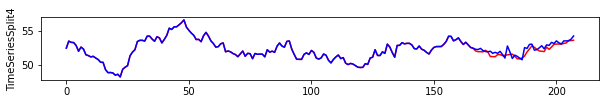

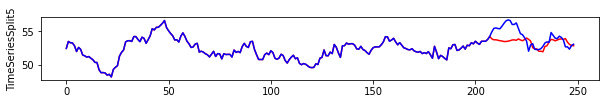

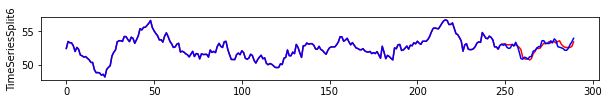

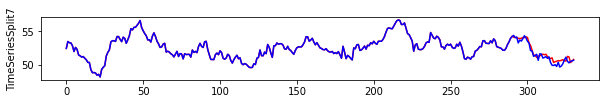

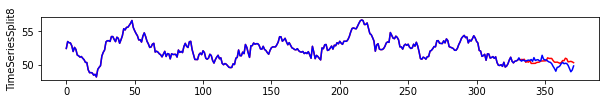

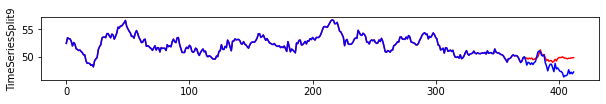

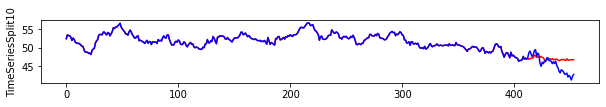

In [21]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

3.1452150842435525


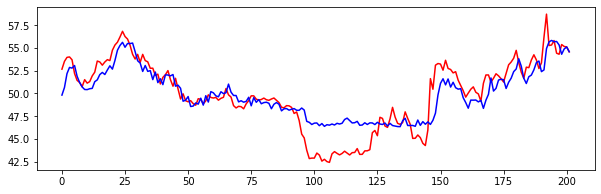

In [22]:
start = '2019-01-01'
end = '2020-01-01'
test = pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])#Choose the data
test_m=test.iloc[51::]
test_fea=features(test)
test_fea=test_fea.iloc[51:]
test_predict=model.predict(test_fea)
msetest=mean_squared_error(test_m,test_predict)
plt.figure(figsize=(10,3))
true=np.asarray(test_m).reshape(len(test_m))
plt.plot(true,"r",label='Predicted')
plt.plot(test_predict,"b",label='Original')
print(msetest)

1.3887073468451
0.5246714879382436
1.1157775481768157
0.6433486075200163
2.351620647546242
0.34027921693738855
0.36078657402206926
0.3885443917558693
3.6512908685697587
6.918529682697604
The last MSE: 6.918529682697604
The average MSE: 1.7683556372009108


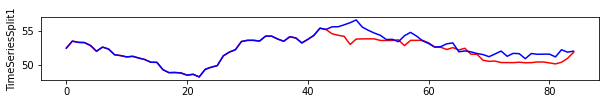

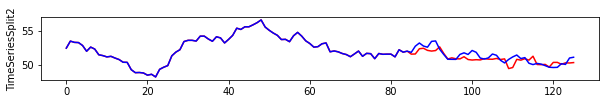

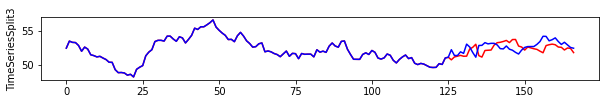

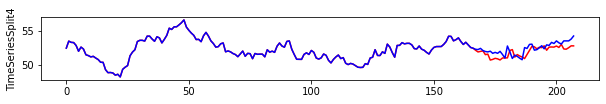

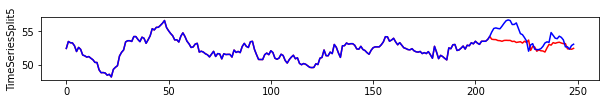

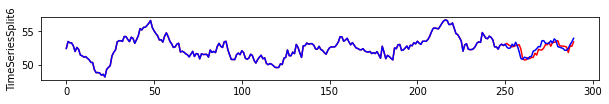

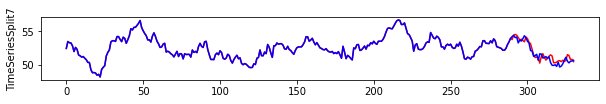

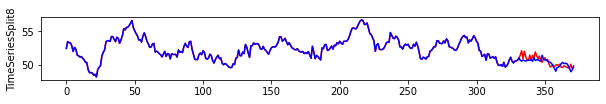

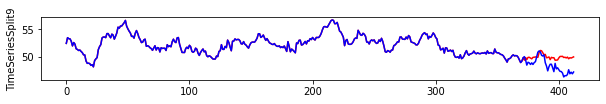

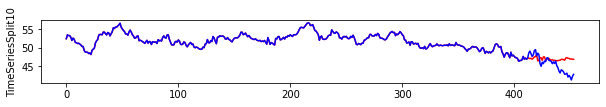

In [23]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

3.16553123458267


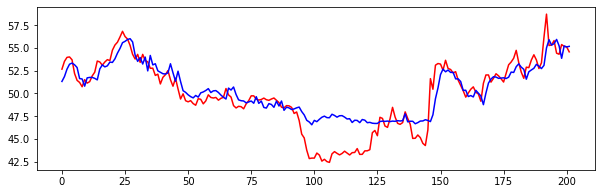

In [24]:
start = '2019-01-01'
end = '2020-01-01'
testo = pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])#Choose the data
test_mo=testo.iloc[51::]
test_feao=features(testo)
test_feao=test_feao.iloc[51:]
test_predicto=model.predict(test_feao)
msetesto=mean_squared_error(test_mo,test_predicto)
plt.figure(figsize=(10,3))
trueo=np.asarray(test_mo).reshape(len(test_mo))
plt.plot(trueo,"r",label='Predicted')
plt.plot(test_predicto,"b",label='Original')
print(msetesto)

# EMDCNN

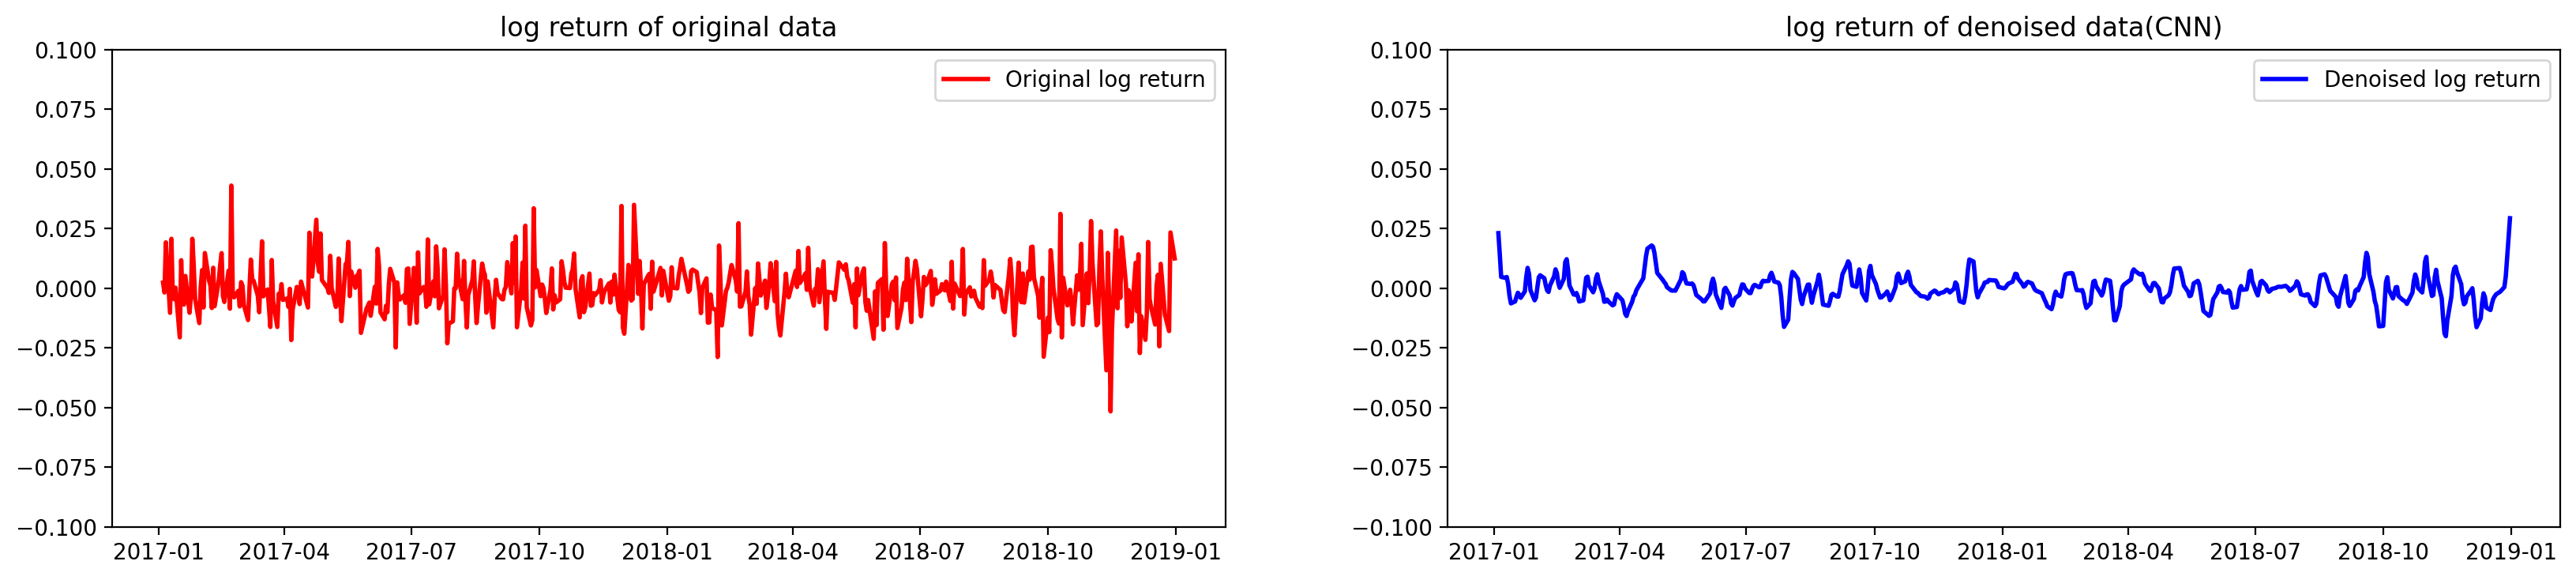

In [25]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()
test['log_ret'] = np.log(test.iloc[:,0]).diff()

plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.1,0.1)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.1,0.1)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [26]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=0.8):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [27]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1,percentage=1)

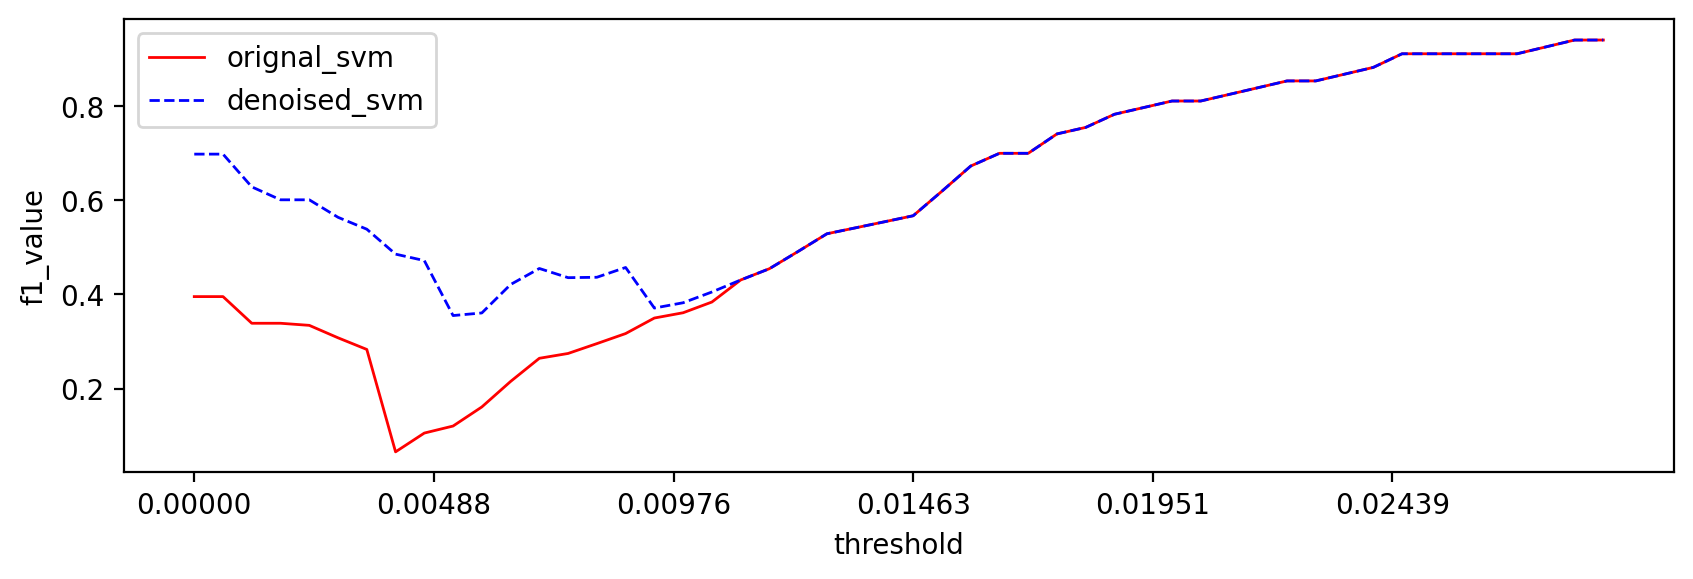

In [28]:
plt.figure(figsize=(10,3),dpi=200)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [29]:
def svmf1_fu(dataset,dataset2,dataset3,long_predict=1,percentage=0.8):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
            
        daily_label3=np.empty(0)#make the data labelled
        for i in range(0,len(dataset3)):
            if dataset3.iloc[i,1]<-threshold:
                n=-1
                daily_label3=np.append(daily_label,n)
            elif abs(dataset3.iloc[i,1])<=threshold:
                n=0
                daily_label3=np.append(daily_label3,n)
            else:
                n=1
                daily_label3=np.append(daily_label3,n)
        Xf=pd.DataFrame()
        Yf=pd.DataFrame()
        for i in range(1,len(dataset3)-long_predict):
            Xf=pd.concat([Xf, pd.DataFrame(dataset3.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Yf=pd.concat([Yf, pd.DataFrame(daily_label3[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        Xf=np.array(Xf)
        Yf=np.array(Yf[0])
        
        X=np.array(X)
        Y=np.array(Y[0])
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X,Y)
        Yp = model.predict(Xf)
        f1 = f1_score(Yf,Yp,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        
        daily_label3=np.empty(0)#make the data labelled
        for i in range(0,len(dataset3)):
            if dataset3.iloc[i,1]<-threshold:
                n=-1
                daily_label3=np.append(daily_label,n)
            elif abs(dataset3.iloc[i,1])<=threshold:
                n=0
                daily_label3=np.append(daily_label3,n)
            else:
                n=1
                daily_label3=np.append(daily_label3,n)
        Xf=pd.DataFrame()
        Yf=pd.DataFrame()
        for i in range(1,len(dataset3)-long_predict):
            Xf=pd.concat([Xf, pd.DataFrame(dataset3.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Yf=pd.concat([Yf, pd.DataFrame(daily_label3[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        Xf=np.array(Xf)
        Yf=np.array(Yf[0])
        
        X=np.array(X)
        Y=np.array(Y[0])
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X,Y)
        Yp = model.predict(Xf)
        f1 = f1_score(Yf,Yp,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [30]:
original_svm_ori,denoised_svm_ori=svmf1_fu(GSPC_test_n,pure_mm_cnn,test, long_predict=1,percentage=1)

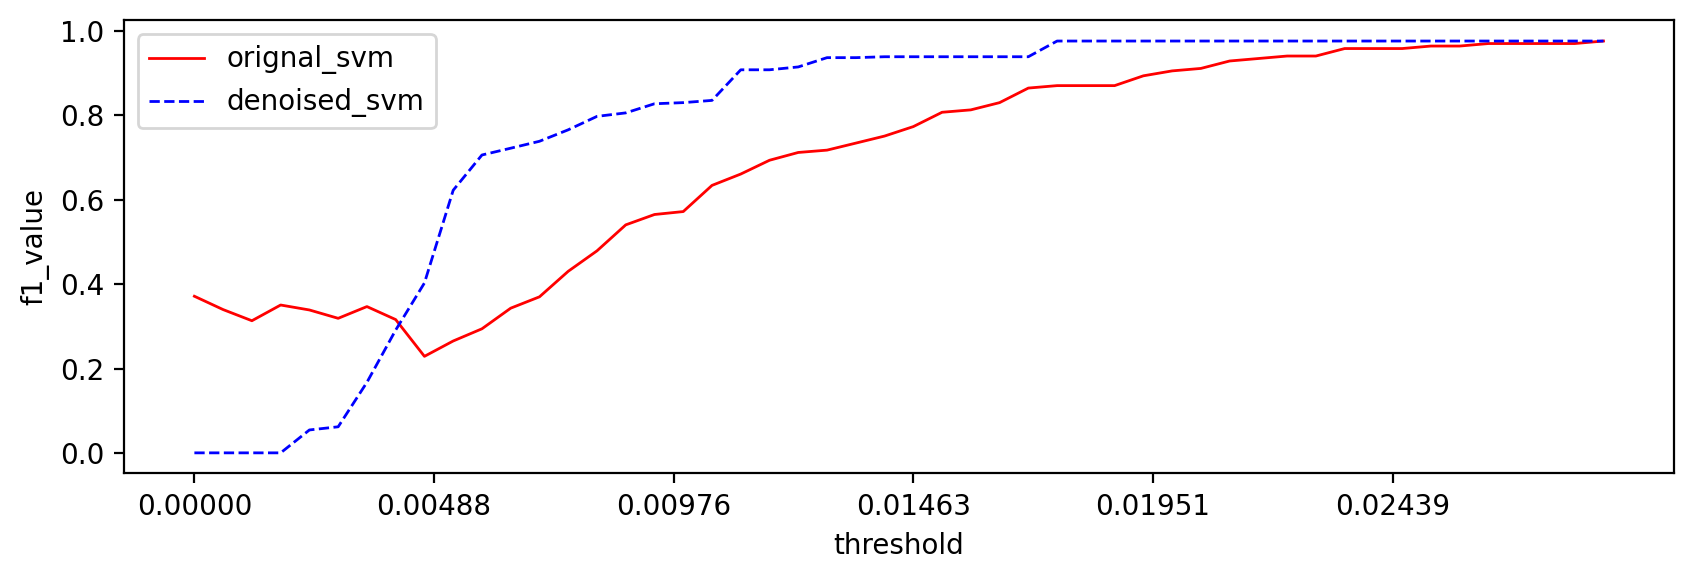

In [31]:
plt.figure(figsize=(10,3),dpi=200)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

# Strategies 

## Bollinger band

In [32]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [33]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Adj Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Adj Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [34]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)


pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn)


In [35]:

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')


GSPC_test_signal:
 -1.0    14
 1.0    12
Name: signal, dtype: int64 

pure_mm_cnn_signal:
  1.0    10
-1.0     8
Name: signal, dtype: int64 



In [36]:
print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == 1.0])

            Adj Close
Date                 
2017-03-27  51.450058
2017-04-06  49.243916
2018-02-06  52.019314
2018-03-23  50.910847
2018-05-31  51.245914
2018-06-05  50.662197
2018-08-13  49.762291
2018-08-31  48.941994
2018-09-07  48.479813
2018-10-02  47.431644
2018-11-16  44.980412
2018-12-10  43.651634
            Adj Close
Date                 
2017-03-27  51.450058
2017-04-04  50.343445
2017-06-13  53.115902
2017-08-30  49.998917
2017-12-05  51.217438
2018-02-05  53.544437
2018-03-22  51.932835
2018-05-30  52.048531
2018-08-08  50.410870
2018-12-10  43.651634


In [37]:
print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == -1.0])

            Adj Close
Date                 
2017-02-15  51.849670
2017-02-22  53.563393
2017-04-27  53.410172
2017-05-25  56.608437
2017-07-19  52.720963
2017-07-25  53.433407
2017-09-14  52.200130
2017-09-21  53.025578
2017-10-26  54.189079
2018-01-10  54.228390
2018-08-01  51.408054
2018-09-20  50.832001
2018-11-02  49.098808
2018-11-08  49.230862
            Adj Close
Date                 
2017-02-14  51.096558
2017-02-21  51.311729
2017-04-27  53.410172
2017-07-18  51.807175
2017-12-11  52.388798
2018-01-10  54.228390
2018-08-01  51.408054
2018-09-20  50.832001


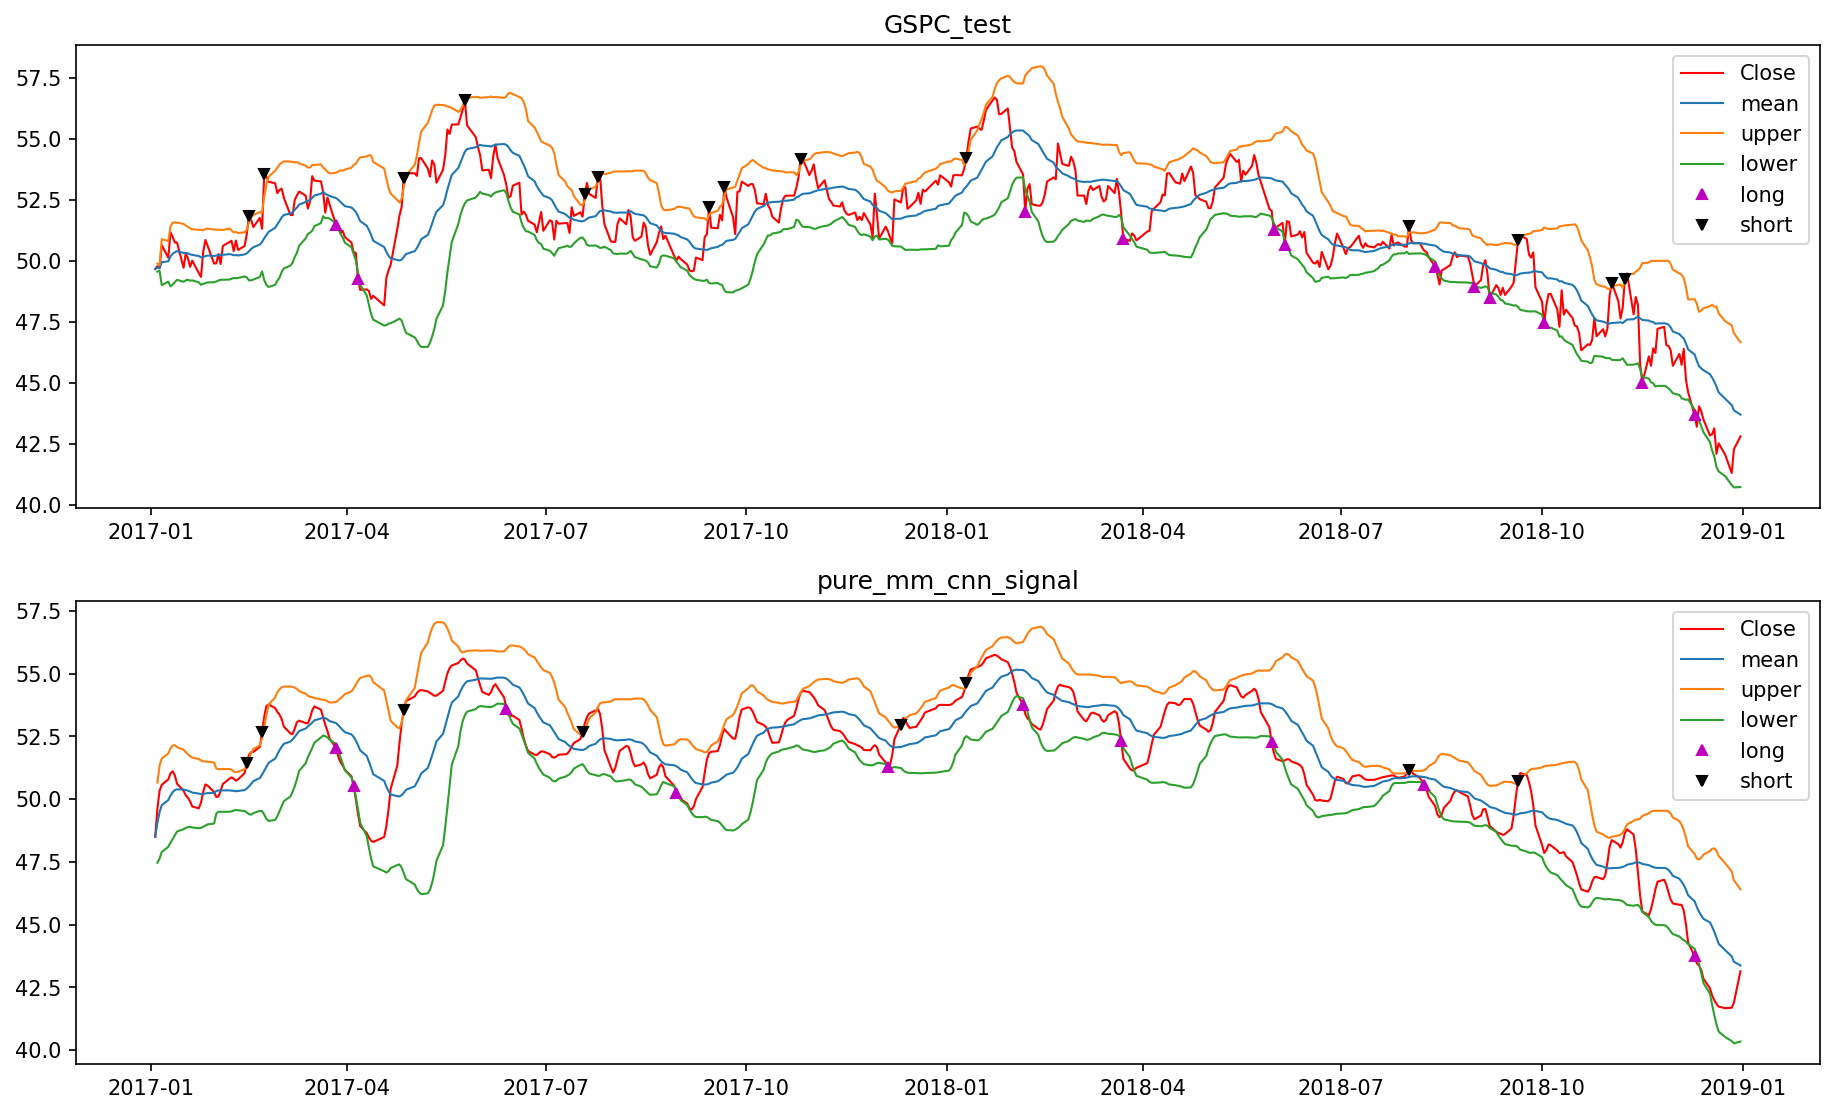

In [38]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn_signal')
plt.plot(pure_mm_cnn_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    


## MACD

In [39]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Adj Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Adj Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

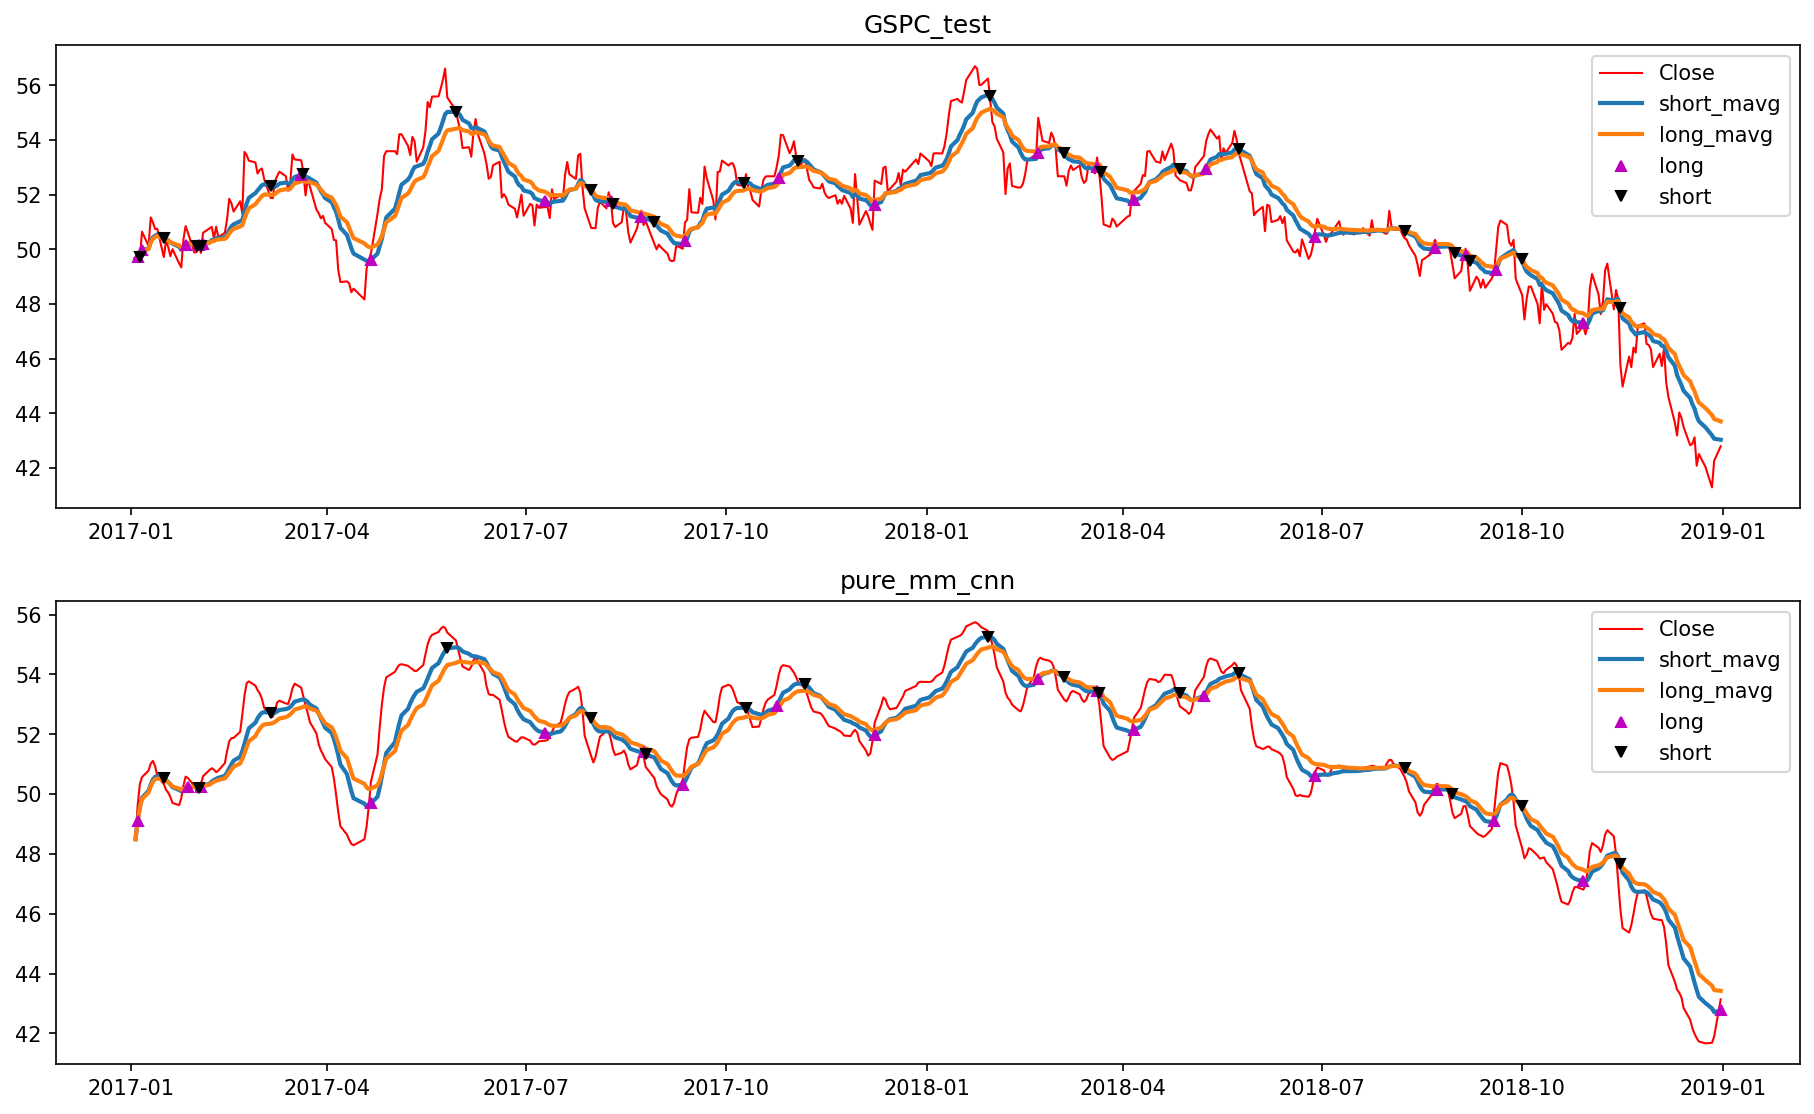

In [40]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnn_macd=MACD(pure_mm_cnn,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [41]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnn_macd:\n',pure_mm_cnn_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    460
 1.0     22
-1.0     22
Name: positions, dtype: int64 

pure_mm_cnn_macd:
  0.0    469
 1.0     18
-1.0     17
Name: positions, dtype: int64 



In [42]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnn_macd['positions']==1])

            Adj Close
Date                 
2017-01-04  49.774757
2017-01-06  50.643154
2017-01-26  50.850647
2017-02-01  50.274277
2017-02-03  50.604725
2017-03-20  53.256004
2017-04-21  49.847950
2017-07-10  51.543877
2017-08-09  51.814922
2017-08-23  51.413979
2017-09-12  50.973732
2017-10-25  53.410797
2017-12-08  52.514587
2018-02-21  54.810131
2018-03-20  53.355759
2018-04-06  52.137238
2018-05-09  53.945621
2018-06-28  50.710831
2018-08-22  50.345058
2018-09-05  50.023174
2018-09-19  49.957146
2018-10-29  47.192295
            Adj Close
Date                 
2017-01-04  49.774757
2017-01-27  50.620094
2017-02-02  49.866978
2017-04-21  49.847950
2017-07-10  51.543877
2017-08-24  50.887264
2017-09-11  50.022495
2017-10-24  52.986275
2017-12-08  52.514587
2018-02-21  54.810131
2018-03-20  53.355759
2018-04-06  52.137238
2018-05-08  53.410549
2018-06-28  50.710831
2018-08-23  50.146976
2018-09-18  49.107059
2018-10-29  47.192295
2018-12-31  42.793297


In [43]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnn_macd['positions']==-1])

            Adj Close
Date                 
2017-01-05  49.682545
2017-01-16  49.713284
2017-01-31  49.897728
2017-02-02  49.866978
2017-03-06  51.880409
2017-03-21  52.825645
2017-05-30  55.075130
2017-07-31  50.784969
2017-08-10  50.965881
2017-08-29  50.195454
2017-10-09  52.318050
2017-11-03  52.978413
2018-01-30  55.439053
2018-03-05  52.671818
2018-03-22  51.932835
2018-04-27  52.526863
2018-05-24  53.507835
2018-08-08  50.410870
2018-08-31  48.941994
2018-09-07  48.479813
2018-10-01  48.314743
2018-11-15  45.764484
            Adj Close
Date                 
2017-01-16  49.713284
2017-02-01  50.274277
2017-03-06  51.880409
2017-05-26  55.555248
2017-07-31  50.784969
2017-08-25  51.028767
2017-10-10  52.750423
2017-11-06  53.300735
2018-01-29  56.248783
2018-03-05  52.671818
2018-03-21  52.797607
2018-04-27  52.526863
2018-05-24  53.507835
2018-08-08  50.410870
2018-08-30  49.437191
2018-10-01  48.314743
2018-11-15  45.764484


## MA

In [44]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Adj Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Adj Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

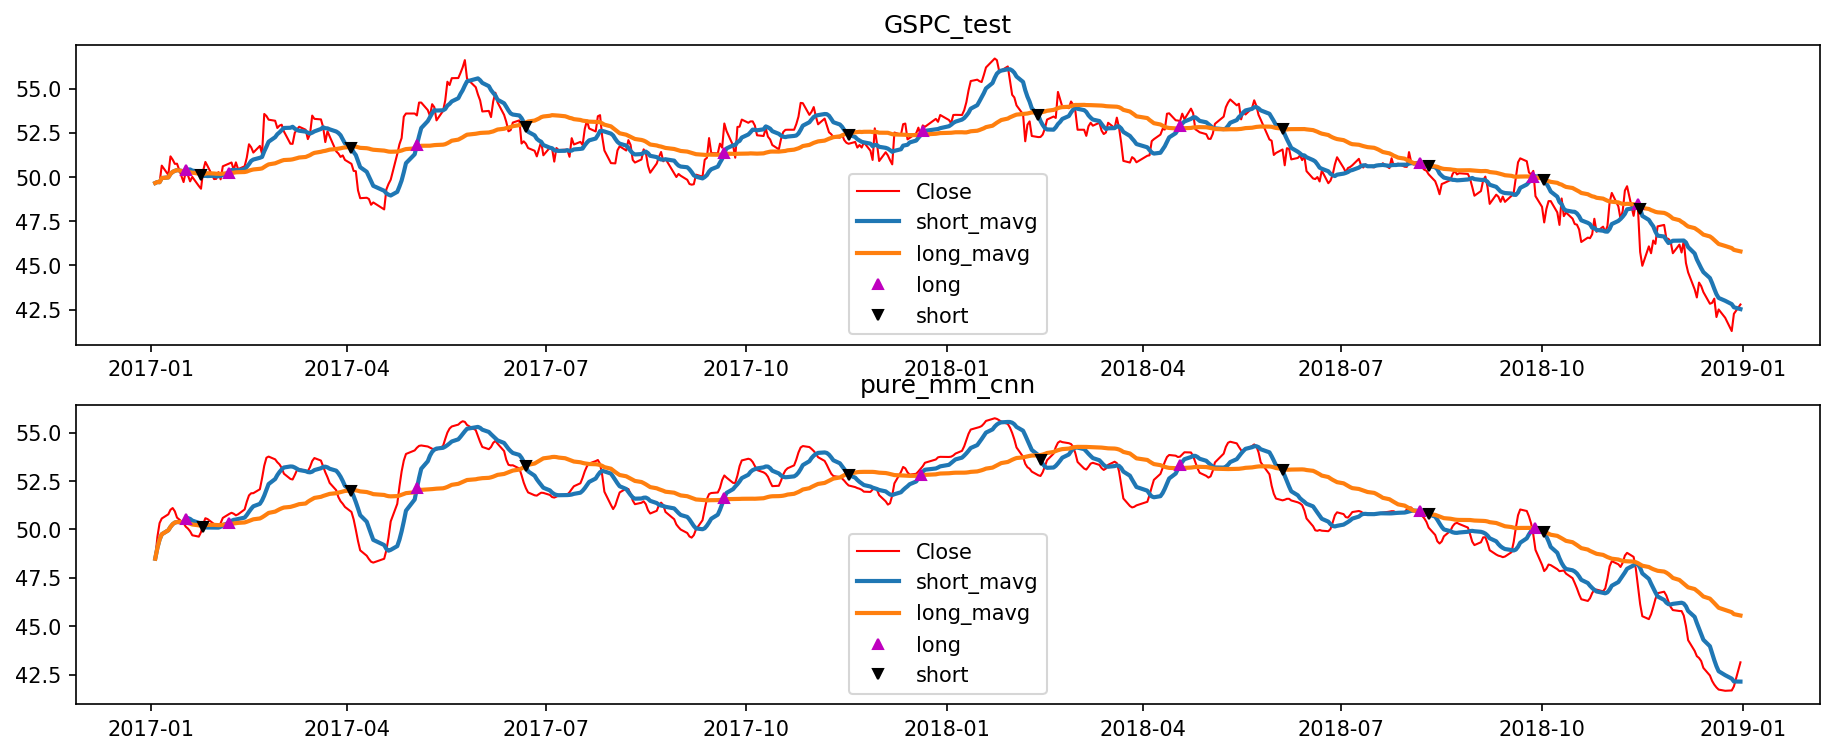

In [45]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnn_ma=MA(pure_mm_cnn,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == 1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == -1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [46]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnn_ma:\n',pure_mm_cnn_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    486
 1.0      9
-1.0      9
Name: positions, dtype: int64 

pure_mm_cnn_ma:
  0.0    488
 1.0      8
-1.0      8
Name: positions, dtype: int64 



In [47]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnn_ma['positions']==1])

            Adj Close
Date                 
2017-01-17  50.297333
2017-02-06  50.766109
2017-05-03  53.479866
2017-09-21  53.025578
2017-12-21  52.915512
2018-04-18  53.159222
2018-08-06  50.727051
2018-09-27  50.345058
2018-11-14  48.190945
            Adj Close
Date                 
2017-01-17  50.297333
2017-02-06  50.766109
2017-05-03  53.479866
2017-09-21  53.025578
2017-12-20  52.333771
2018-04-18  53.159222
2018-08-06  50.727051
2018-09-28  48.917236


In [48]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnn_ma['positions']==-1])

            Adj Close
Date                 
2017-01-24  49.336727
2017-04-03  50.743053
2017-06-22  51.884613
2017-11-17  51.877800
2018-02-12  52.255150
2018-06-04  51.553989
2018-08-10  50.151432
2018-10-02  47.431644
2018-11-15  45.764484
            Adj Close
Date                 
2017-01-25  50.366497
2017-04-03  50.743053
2017-06-22  51.884613
2017-11-17  51.877800
2018-02-13  52.263027
2018-06-04  51.553989
2018-08-10  50.151432
2018-10-02  47.431644


## Strategies backtest

In [49]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Adj Close']=dataset['Adj Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [50]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnn_backtesting=combinesig(GSPC_test,pure_mm_cnn_ma,pure_mm_cnn_macd,pure_mm_cnn_signal)


In [51]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Adj Close'][i])*100
            if cash//(100*dataset['Adj Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Adj Close'][i])*100*dataset['Adj Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Adj Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Adj Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [52]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnn)


-0.21164247505950928
-0.1179535625114441


In [53]:
macdreturn=backtest(GSPC_backtesting,signal='macdsig')
macdreturn_cnn=backtest(pure_mm_cnn_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(macdreturn)
print(macdreturn_cnn)
#print(mareturn_lstm)

-0.105409239112854
0.15872532719039917


In [54]:
bbreturn=backtest(GSPC_backtesting,signal='bbsig')
bbreturn_cnn=backtest(pure_mm_cnn_backtesting,signal='bbsig')
print(bbreturn)
print(bbreturn_cnn)


0.03204091036605835
0.006900378837585449
